# Overview of what will do below:
- load lidar data (3d points), these points are in coordinate system of the lidar, rotated and translated relative to the car;
- using sensor information of the lidar, translate points from lidar coordinate frame to car coordinate frame, merge data from all 3 lidars;
- annotations are in global coordinates. translate annotations into the car coordinates, both the data and annotations are in the same (car) coordinate frame, 
which can then be used for training.

In [1]:
%matplotlib inline
import json
import os.path

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pyquaternion import Quaternion

In [5]:
# load jason data
class Table:
    def __init__(self, data):
        self.data = data
        self.index = {x['token']: x for x in data}


DATA_ROOT = '/workspace/auto_driving/data/lyft_3d/'


def load_table(name, root=os.path.join(DATA_ROOT, 'train_data')):
    with open(os.path.join(root, name), 'rb') as f:
        return Table(json.load(f))

    
scene = load_table('scene.json')
sample = load_table('sample.json')
sample_data = load_table('sample_data.json')
ego_pose = load_table('ego_pose.json')
calibrated_sensor = load_table('calibrated_sensor.json')

In [7]:
# check the first scene
my_scene = scene.data[0]
my_scene

{'log_token': 'da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952e158e5589854af9f100',
 'first_sample_token': '24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8',
 'name': 'host-a101-lidar0-1241893239199111666-1241893264098084346',
 'description': '',
 'last_sample_token': '2346756c83f6ae8c4d1adec62b4d0d31b62116d2e1819e96e9512667d15e7cec',
 'nbr_samples': 126,
 'token': 'da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952e158e5589854af9f100'}

In [9]:
# first sample from the scene
sample.index[my_scene['first_sample_token']]

{'next': 'c2ba18e4414ce9038ad52efab44e1a0a211ff1e6b297a632805000510756174d',
 'prev': '',
 'token': '24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8',
 'timestamp': 1557858039302414.8,
 'scene_token': 'da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952e158e5589854af9f100'}

In [10]:
sample_data.data[0]

{'is_key_frame': True,
 'prev': 'd190078ec7869ad5c9e5417371aa3b45eb1c22804a0a290ed4695042799b7470',
 'fileformat': 'bin',
 'token': 'ad87e1763749cc8562cca68e2046db128185c80c3e759919f5da448e5d9d9696',
 'timestamp': 1549920983701948.2,
 'next': '8182fb6868baf63c245a4994b7f3034a7d281d1928a7844b7b7159cff3b91a1e',
 'ego_pose_token': 'd90d278f2084ae64c98b0aa2dd8d4f83c023f1313beeaebdcefbf4529209237f',
 'sample_token': 'fd5f1c634b59e3b4e0f7a5c48c768a7d334a63221fced363a2ebac41f465830d',
 'filename': 'lidar/host-a007_lidar1_1233956183701948366.bin',
 'calibrated_sensor_token': '3b463530b5bae9698c9cc803c1731c36abd359a7296e23e81f8c0b546f60e749'}

In [12]:
# fetch lidar images related to the sample 
lidars = []
for x in sample_data.data:
    if x['sample_token'] == my_scene['first_sample_token'] and 'lidar' in x['filename']:
        lidars.append(x)
lidars

[{'is_key_frame': True,
  'prev': '',
  'fileformat': 'bin',
  'token': '8cfae06bc3d5d7f9be081f66157909ff18c9f332cc173d962460239990c7a4ff',
  'timestamp': 1557858039302414.8,
  'next': 'c9dfdcd012a4946eae21a83e52e45de09ca930621e7ca7c5b78503a73509fb31',
  'ego_pose_token': '2d673d4bee560c77788b91e2ee24503538e74a23e7972e3e0099b92015f76dde',
  'sample_token': '24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8',
  'calibrated_sensor_token': 'dd9aad0c2aa0c75b9b0e227b568f64aac54f72c67956e759d6c629778c7734ef',
  'filename': 'lidar/host-a101_lidar2_1241893239302414726.bin'},
 {'is_key_frame': True,
  'prev': '',
  'fileformat': 'bin',
  'token': 'ec9950f7b5d4ae85ae48d07786e09cebbf4ee771d054353f1e24a95700b4c4af',
  'timestamp': 1557858039302414.8,
  'next': 'b2fb6b275352ff1bc8d63cae2ec88561dddb044cae6f8e6ee7ada4ed07d79dc7',
  'ego_pose_token': '2d673d4bee560c77788b91e2ee24503538e74a23e7972e3e0099b92015f76dde',
  'sample_token': '24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db2

In [13]:
{x['ego_pose_token'] for x in lidars}
# All lidars happen to have the same ego_pose

{'2d673d4bee560c77788b91e2ee24503538e74a23e7972e3e0099b92015f76dde'}

In [15]:
# load lidar points data(only the 3 columns of point coordinates)
lidars_data = [
    np.fromfile(os.path.join(DATA_ROOT, x['filename']).replace('/lidar/', '/train_lidar/'), dtype=np.float32)
    .reshape(-1, 5)[:, :3] for x in lidars]
lidars_data[0].shape

(38647, 3)

In [16]:
lidars_data[0]

array([[  0.19340175,  -3.5272639 ,   0.44653624],
       [  0.20548166,  -3.5226066 ,   0.44602883],
       [  0.21728648,  -3.5139477 ,   0.44501394],
       ...,
       [ -6.601818  , -43.266674  , -12.16834   ],
       [ -6.439784  , -43.267715  , -12.161906  ],
       [ -6.3086553 , -43.42722   , -12.200512  ]], dtype=float32)

In [17]:
lidars_data[0].min(axis=0), lidars_data[0].max(axis=0)

(array([-175.38388, -200.30618,  -17.71042], dtype=float32),
 array([ 53.690228, 196.61893 ,   1.24078 ], dtype=float32))

# Translate all lidars into car coordinate system

In [19]:
[calibrated_sensor.index[x['calibrated_sensor_token']] for x in lidars]

[{'sensor_token': '953faed96fd3d2fae3ec03cd2838b312b8c1a9bb7a0629481982870cb28acb67',
  'rotation': [0.003651633245269522,
   0.6883656521848035,
   0.7253545303479662,
   0.0004469569487147289],
  'camera_intrinsic': [],
  'translation': [3.4979440634654573, -0.9496511625133583, 0.5473180779313758],
  'token': 'dd9aad0c2aa0c75b9b0e227b568f64aac54f72c67956e759d6c629778c7734ef'},
 {'sensor_token': '25bf751d7e35f295393d8a418731474b21c1f702e878c4553f112397caa48c08',
  'rotation': [0.006336712035703651,
   -0.011344169002788682,
   7.18908018654885e-05,
   0.9999155718069028],
  'camera_intrinsic': [],
  'translation': [1.1970962545449502,
   3.680498291456359e-05,
   1.8279670539933053],
  'token': '82130f5d48b806b62fec95989081337218fbf338ebcc95115d8afcebb305630c'},
 {'sensor_token': '629da739ea3a0814b9d79ffc3b99cdbc8bdbb6f97abf139f1ad33bd12f8fa94d',
  'rotation': [0.01046934325147815,
   0.7290775169266195,
   -0.6842510224225216,
   0.011700661422809379],
  'camera_intrinsic': [],
  'tr

In [20]:
# some helpers
def rotate_points(points, rotation, inverse=False):
    assert points.shape[1] == 3
    q = Quaternion(rotation)
    if inverse:
        q = q.inverse
    return np.dot(q.rotation_matrix, points.T).T
    
def apply_pose(points, cs):
    """ Translate (lidar) points to vehicle coordinates, given a calibrated sensor.
    """
    points = rotate_points(points, cs['rotation'])
    points = points + np.array(cs['translation'])
    return points

def inverse_apply_pose(points, cs):
    """ Reverse of apply_pose (we'll need it later).
    """
    points = points - np.array(cs['translation'])
    points = rotate_points(points, np.array(cs['rotation']), inverse=True)
    return points


In [21]:
#vizualize all lidars
def viz_all_lidars(lidars, lidars_data, clip=50, skip_apply_pose=False):
    all_points = []
    all_colors = []
    for color, points, lidar in zip([[1, 0, 0, 0.5], [0, 1, 0, 0.5], [0, 0, 1, 0.5]], lidars_data, lidars):
        cs = calibrated_sensor.index[lidar['calibrated_sensor_token']]
        if not skip_apply_pose:
            points = apply_pose(points, cs)
        all_points.append(points)
        all_colors.append(np.array([color] * len(points)))
    all_points = np.concatenate(all_points)
    all_colors = np.concatenate(all_colors)
    perm = np.random.permutation(len(all_points))
    all_points = all_points[perm]
    all_colors = all_colors[perm]

    plt.figure(figsize=(12, 12))
    plt.axis('equal')
    plt.grid()
    plt.scatter(np.clip(all_points[:, 0], -clip, clip), np.clip(all_points[:, 1], -clip, clip), s=1, c=all_colors)

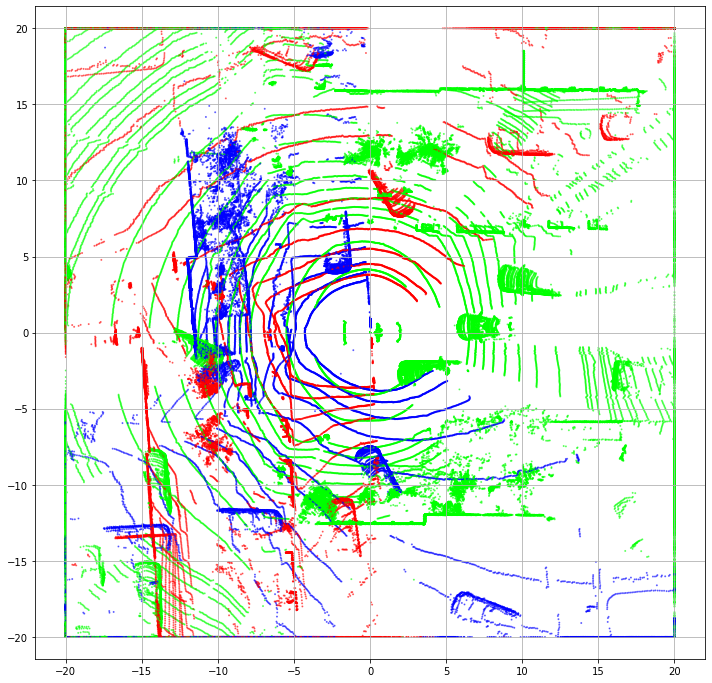

In [22]:
# don't use poses from the lidars
viz_all_lidars(lidars, lidars_data, clip=20, skip_apply_pose=True)

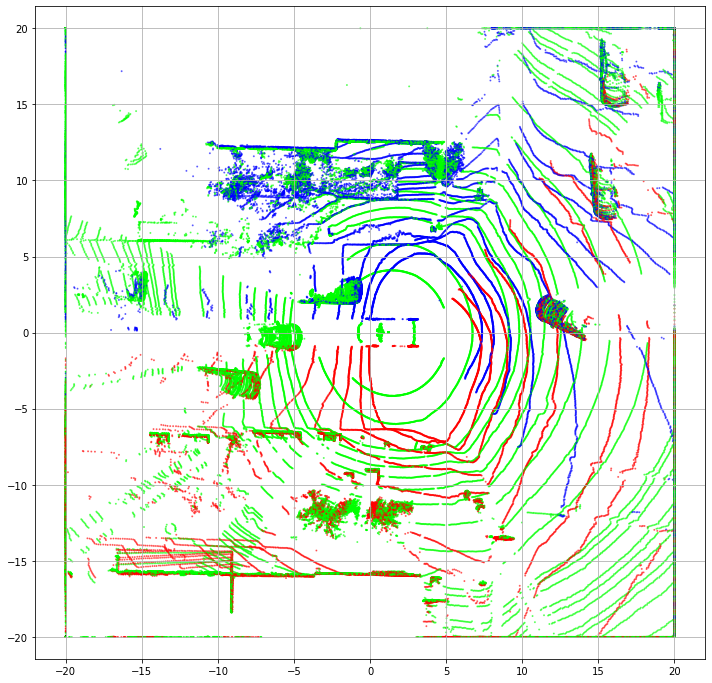

In [23]:
#use poses from the lidars
viz_all_lidars(lidars, lidars_data, clip=20, skip_apply_pose=False)

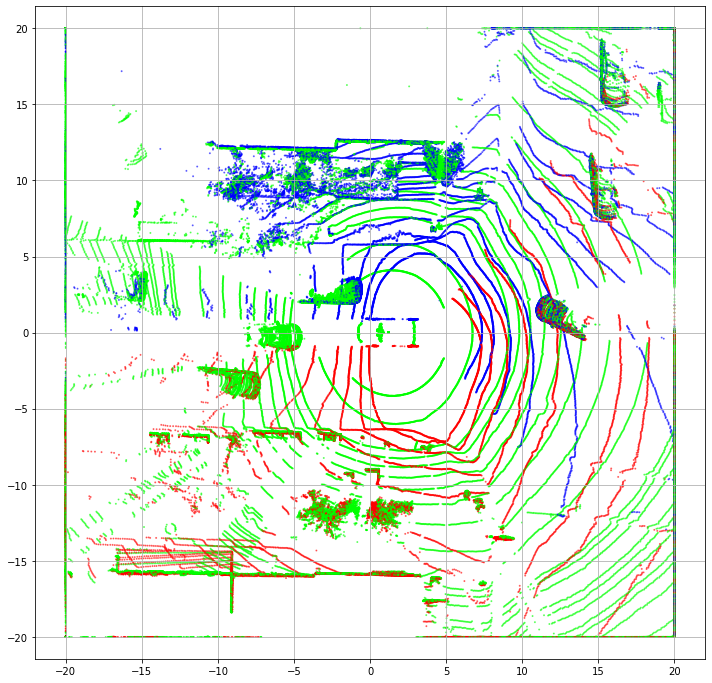

In [24]:
viz_all_lidars(lidars, lidars_data, clip=20)
# curvy lines come from the ground and don't need to aling, mostly, cars will be checked alignment.

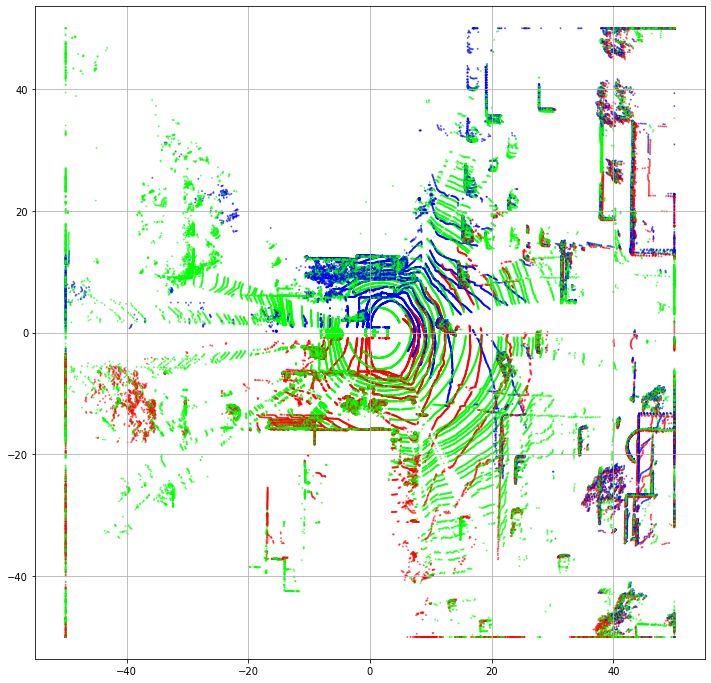

In [25]:
viz_all_lidars(lidars, lidars_data, clip=50)

# Translate all annotations into car coordinate system

In [26]:
# load annotation data from train.csv
train_df = pd.read_csv(os.path.join(DATA_ROOT, 'train.csv')).set_index('Id')
train_df.loc[my_scene['first_sample_token']]

PredictionString    1048.155950230245 1691.8102354006162 -23.30494...
Name: 24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8, dtype: object

In [27]:
# convert annotation data from string
def get_annotations(token):
    annotations = np.array(train_df.loc[token].PredictionString.split()).reshape(-1, 8)
    return {
        'point': annotations[:, :3].astype(np.float32),
        'wlh': annotations[:, 3:6].astype(np.float32),
        'rotation': annotations[:, 6].astype(np.float32),
        'cls': np.array(annotations[:, 7]),
    }

get_annotations(my_scene['first_sample_token']).keys()

dict_keys(['point', 'wlh', 'rotation', 'cls'])

In [28]:
# annotations are in global coordinates. translate them into the frame of the car by using the ego_pose of the lidars (they are all the same)
ego_pose.index[lidars[0]['ego_pose_token']]

{'rotation': [-0.6004078747001647,
  -0.000868287440477653,
  0.0018651459228554272,
  0.7996912850004297],
 'translation': [1007.2332778546752, 1725.4217301399465, -24.58000073380586],
 'token': '2d673d4bee560c77788b91e2ee24503538e74a23e7972e3e0099b92015f76dde',
 'timestamp': 1557858039302414.8}

In [31]:
# use inverse_apply_pose, show only the car class, and will deal only with point centers
def viz_annotation_centers(token, lidars, clip=50):
    # translate annotation points to the car frame
    ego_pose_token, = {x['ego_pose_token'] for x in lidars}
    ep = ego_pose.index[ego_pose_token]
    annotations = get_annotations(token)
    car_points = annotations['point'][annotations['cls'] == 'car']
    car_points = inverse_apply_pose(car_points, ep)
    
    plt.scatter(np.clip(car_points[:, 0], -clip, clip),
                np.clip(car_points[:, 1], -clip, clip),
                s=30,
                color='black')

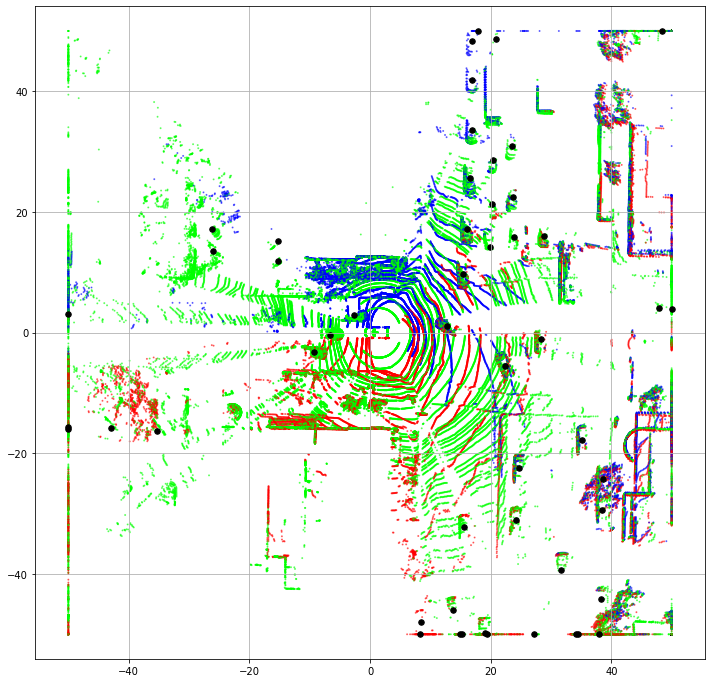

In [29]:
viz_all_lidars(lidars, lidars_data, clip=50)
viz_annotation_centers(my_scene['first_sample_token'], lidars, clip=50)

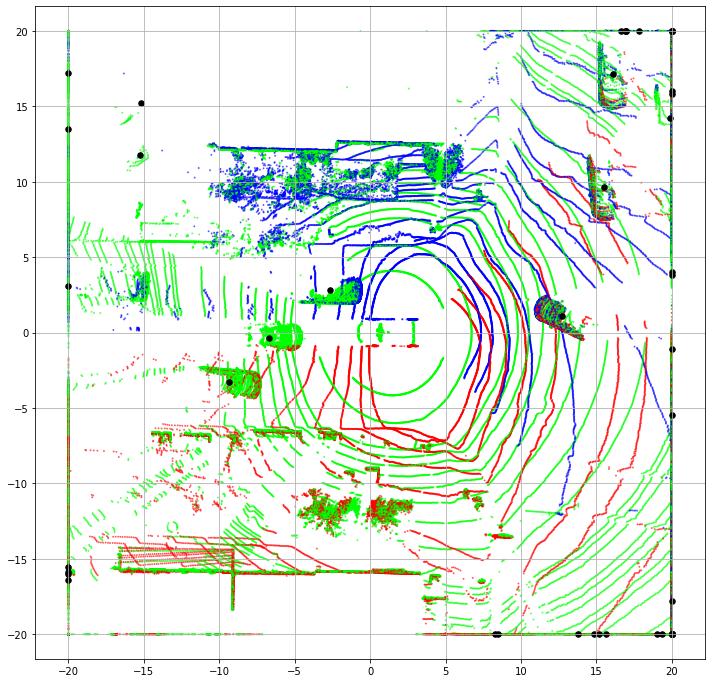

In [30]:
viz_all_lidars(lidars, lidars_data, clip=20)
viz_annotation_centers(my_scene['first_sample_token'], lidars, clip=20)